# Assignment 6: Imputation via Regression for Missing Data
---
**Author:** Yash Purswani\
**Roll Number:** ME22B214

### Objective:

This notebook implements 4 strategies for data imputation:

- Dataset A: Median imputation (baseline)
- Dataset B: Linear regression imputation (for one chosen column)
- Dataset C: Non-linear regression imputation (Random Forest Regressor for the same column)
- Dataset D: Listwise deletion (drop rows with any missing values)

It trains a Logistic Regression classifier on each dataset and compares classification metrics.

In [15]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Part A: Data Pre-Processing and Imputation

### Loading the dataset

The cell loads the data in `UCI_Credit_Card.csv` for pre-processing taken from [Kaggle - Default of Credit Card Clients Dataset](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset).

In [16]:
try:
    df = pd.read_csv(f'UCI_Credit_Card.csv', header=0)
    print(f"Loaded dataset from UCI_Credit_Card.csv")

except Exception:
    df = None

if df is None:
    raise FileNotFoundError(
        "Could not find dataset CSV. Please put UCI_Credit_Card.csv in the notebook directory."
    )

print('Shape:', df.shape)
print(df.columns)

Loaded dataset from UCI_Credit_Card.csv
Shape: (30000, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


### Introducing Artificial MAR Values

We'll introduce ~7% Missing At Random (MAR) in 3 numerical columns: `AGE`, `BILL_AMT1`, `LIMIT_BAL`.

MAR: missingness depends on other (observed) variables but not directly on missing values themselves. We simulate by randomly choosing rows to set NaN within groups defined by another variable (e.g., `EDUCATION`).

In [17]:
data = df.copy()
cols = [c.strip() for c in data.columns]

if 'AGE' not in data.columns:
    for c in data.columns:
        if c.lower() == 'age':
            data.rename(columns={c: 'AGE'}, inplace=True)
if 'BILL_AMT1' not in data.columns:
    for c in data.columns:
        if 'BILL_AMT1' in c.upper():
            data.rename(columns={c: 'BILL_AMT1'}, inplace=True)
if 'LIMIT_BAL' not in data.columns:
    for c in data.columns:
        if 'LIMIT_BAL' in c.upper():
            data.rename(columns={c: 'LIMIT_BAL'}, inplace=True)

if 'AGE' not in data.columns or 'BILL_AMT1' not in data.columns or 'LIMIT_BAL' not in data.columns:
    raise ValueError('Required columns AGE, BILL_AMT1, LIMIT_BAL not found in dataset. Check column names.')

# Choose 3 numerical columns to introduce MAR missingness
num_cols = ['AGE', 'BILL_AMT1', 'LIMIT_BAL']

# Choose a column to depend on for MAR mechanism
condition_col = 'EDUCATION'

# Group by EDUCATION and introduce 5–10% missingness differently per group
for i in range(len(num_cols)):
    for edu_level, group in data.groupby('EDUCATION'):
        # Missing percentage for the group
        rng = np.random.default_rng(seed=RANDOM_STATE+edu_level)
        missing_frac = rng.uniform(0.05, 0.10)
        
        # Randomly sample that fraction of rows within this education group
        missing_idx = group.sample(frac=missing_frac, random_state=RANDOM_STATE+i).index
        
        # Set those values to NaN in the selected column
        data.loc[missing_idx, num_cols[i]] = np.nan

# check summary of missing values

print('Introduced missing values:')
print('AGE missing %:', data['AGE'].isna().mean()*100)
print('BILL_AMT1 missing %:', data['BILL_AMT1'].isna().mean()*100)
print('LIMIT_BAL missing %:', data['LIMIT_BAL'].isna().mean()*100)

Introduced missing values:
AGE missing %: 6.963333333333334
BILL_AMT1 missing %: 6.963333333333334
LIMIT_BAL missing %: 6.963333333333334


### Dataset A: Median imputation (baseline)

In [18]:
A = data.copy()
median_imputer = SimpleImputer(strategy='median')
A_numeric = A.select_dtypes(include=[np.number])
A_numeric_cols = A_numeric.columns
A[A_numeric_cols] = median_imputer.fit_transform(A_numeric)

print('Dataset A ready. Any missing?:', A.isna().any().any())

Dataset A ready. Any missing?: False


The **median** is often preferred over the **mean** for imputing missing values because it is **less sensitive to outliers and skewed distributions**.  
While the mean can be distorted by extreme values, the median represents the central tendency more robustly, preserving the overall data pattern without being biased by large or small anomalies.

### Dataset B: Regression Imputation (Linear)

We'll impute `LIMIT_BAL` using linear regression trained on rows where `LIMIT_BAL` is present.

In [19]:
B = data.copy()
col_to_impute = 'LIMIT_BAL'

reg_train = B[B[col_to_impute].notna()].copy()
reg_pred = B[B[col_to_impute].isna()].copy()

predictor_cols = reg_train.select_dtypes(include=[np.number]).columns.tolist()
if col_to_impute in predictor_cols:
    predictor_cols.remove(col_to_impute)

# Drop rows with NaNs in predictor columns for training
reg_train_clean = reg_train.dropna(subset=predictor_cols)

X_reg = reg_train_clean[predictor_cols]
y_reg = reg_train_clean[col_to_impute]

# Linear Regression for imputation
linreg = LinearRegression()
linreg.fit(X_reg, y_reg)

# Handle missing predictors before prediction
reg_pred_filled = reg_pred[predictor_cols].copy()
for c in predictor_cols:
    if reg_pred_filled[c].isna().any():
        med = X_reg[c].median()
        reg_pred_filled[c] = reg_pred_filled[c].fillna(med)

pred_vals = linreg.predict(reg_pred_filled)
B.loc[reg_pred.index, col_to_impute] = pred_vals

# Now impute remaining numerical columns with median
B_numeric = B.select_dtypes(include=[np.number]).columns
B[B_numeric] = SimpleImputer(strategy='median').fit_transform(B[B_numeric])

print('Dataset B ready. Any missing?:', B.isna().any().any())

Dataset B ready. Any missing?: False


When using a **Linear Regression model** to impute missing values, we train the model on rows where the target feature is **observed** and then use it to **predict missing values** based on the relationships with other non-missing features.  
This approach assumes that the data are **Missing At Random (MAR)** — meaning the probability that a value is missing depends only on other observed variables, **not on the missing value itself**.

For example, if `LIMIT_BAL` is missing more often for certain `EDUCATION` levels or `AGE` groups, but not because of the actual (unseen) `LIMIT_BAL` values, then the MAR assumption holds.  
Under MAR, regression imputation works well because the observed relationships between variables can reliably predict the missing ones.

### Dataset C: Regression Imputation (Random Forest Regressor)

In [20]:
C = data.copy()
col_to_impute = 'LIMIT_BAL'

reg_train = C[C[col_to_impute].notna()].copy()
reg_pred = C[C[col_to_impute].isna()].copy()

predictor_cols = reg_train.select_dtypes(include=[np.number]).columns.tolist()
if col_to_impute in predictor_cols:
    predictor_cols.remove(col_to_impute)

# Drop rows with NaNs in predictor columns for training
reg_train_clean = reg_train.dropna(subset=predictor_cols)
X_reg = reg_train_clean[predictor_cols]
y_reg = reg_train_clean[col_to_impute]

# Random Forest Regressor for imputation
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reg.fit(X_reg, y_reg)

# Handle missing predictors before prediction
reg_pred_filled = reg_pred[predictor_cols].copy()
for c in predictor_cols:
    if reg_pred_filled[c].isna().any():
        med = X_reg[c].median()
        reg_pred_filled[c] = reg_pred_filled[c].fillna(med)

pred_vals = rf_reg.predict(reg_pred_filled)
C.loc[reg_pred.index, col_to_impute] = pred_vals

# Now impute remaining numerical columns with median
C_numeric = C.select_dtypes(include=[np.number]).columns
C[C_numeric] = SimpleImputer(strategy='median').fit_transform(C[C_numeric])

print('Dataset C ready. Any missing?:', C.isna().any().any())

Dataset C ready. Any missing?: False


The **Random Forest Regressor (RFR)** is preferred over the **KNN Imputer** because it can **capture complex, non-linear relationships** between features and is more **robust to outliers**.  
While KNN imputes missing values based on the average of nearby samples in feature space, it relies heavily on distance calculations and can perform poorly when features are on different scales or the dataset is high-dimensional.

RFR, on the other hand, builds an ensemble of decision trees that collectively learn how each feature depends on others.  
It handles both **numerical and categorical** data well, naturally models **interactions and non-linearities**, and produces **more consistent and stable imputations** across the dataset.

### Dataset D: Listwise Deletion

In [21]:
D = data.copy()

# Drop any rows with missing values
D = data.dropna()

print('Dataset D ready. Any missing?:', D.isna().any().any())

Dataset D ready. Any missing?: False


## Part B: Model Training and Performance Assessment

We'll define helper functions to train and evaluate the logistic regression on a dataset.

In [22]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

TARGET_COL = None
if TARGET_COL is None and 'default.payment.next.month' in data.columns:
    TARGET_COL = 'default.payment.next.month'
if TARGET_COL is None:
    TARGET_COL = data.columns[-1]

print('Using target column:', TARGET_COL)

def train_eval(df, dataset_name):
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]

    X_proc = pd.get_dummies(X, drop_first=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if len(y.unique())>1 else None
    )

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Trainning Logistic Regression
    clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"\n=== Results for {dataset_name} ===")
    print(classification_report(y_test, y_pred))

    metrics = {
        'dataset': dataset_name,
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score']
    }
    return metrics

metrics_list = []
for df_obj, name in [(A, 'A_median'), (B, 'B_linear_reg'), (C, 'C_decision_tree_reg'), (D, 'D_listwise')]:
    m = train_eval(df_obj, name)
    metrics_list.append(m)


Using target column: default.payment.next.month

=== Results for A_median ===
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4673
         1.0       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000


=== Results for B_linear_reg ===
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4673
         1.0       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000


=== Results for C_decision_tree_reg ===
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4673
         1.0       0.69      0.24      0.36      1327

    accuracy                 

## Part C: Comparative analysis

Create a summary table comparing performance metrics across datasets.

In [23]:
summary = pd.DataFrame(metrics_list).set_index('dataset')
display(summary)

,accuracy,precision,recall,f1
dataset,,,,
A_median,0.807500,0.752938,0.603118,0.619584
B_linear_reg,0.807667,0.752646,0.604035,0.620791
C_decision_tree_reg,0.808333,0.755357,0.604732,0.621756
D_listwise,0.805785,0.753964,0.598348,0.613016


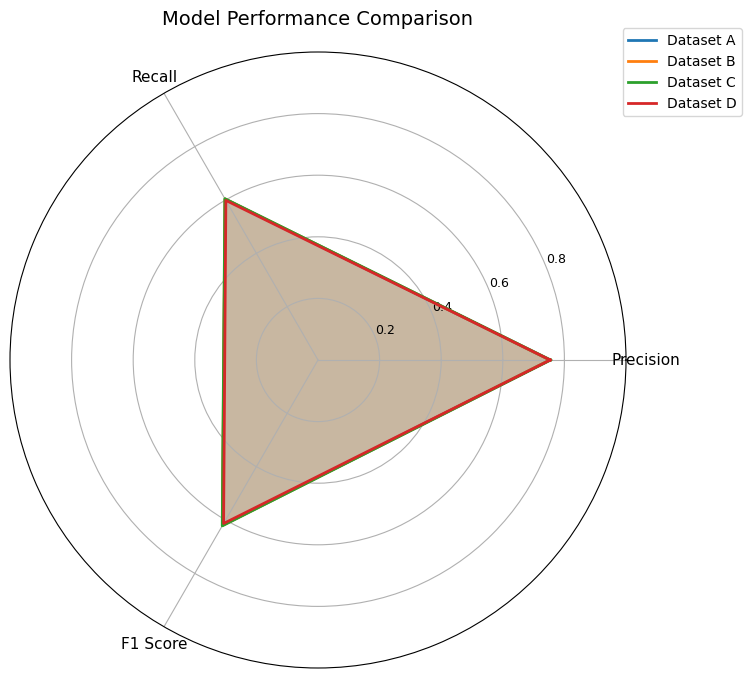

In [24]:
# Example scores for each dataset (replace with your actual values)
scores = {
    'A': summary.loc['A_median', ['precision', 'recall', 'f1']].tolist(),
    'B': summary.loc['B_linear_reg', ['precision', 'recall', 'f1']].tolist(),
    'C': summary.loc['C_decision_tree_reg', ['precision', 'recall', 'f1']].tolist(),
    'D': summary.loc['D_listwise', ['precision', 'recall', 'f1']].tolist()
}

metrics = ['Precision', 'Recall', 'F1 Score']
num_vars = len(metrics)

# Compute angle for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for label, values in scores.items():
    values += values[:1]  # repeat first value to close the circle
    ax.plot(angles, values, label=f'Dataset {label}', linewidth=2)
    ax.fill(angles, values, alpha=0.15)

# Add labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=11)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=9)
ax.set_ylim(0, 1)

# Title and legend
ax.set_title('Model Performance Comparison', size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))

plt.show()


### Discussion

#### 1. Trade-off Between Listwise Deletion (Model D) and Imputation (Models A, B, C)

**Listwise Deletion (Model D)** removes all rows with missing values before training.  
While this ensures the model only learns from complete data, it also **reduces the dataset size**, potentially eliminating informative samples and introducing **sampling bias** if the missingness is not completely random.  
In contrast, **Imputation-based models (A, B, C)** retain all samples by estimating missing values, preserving data quantity and potentially capturing more variability.

Even if imputed models introduce some estimation error, they often **outperform listwise deletion** in generalization because they learn from a larger and more representative dataset.  
However, if the imputation is poor or introduces bias, Model D might still appear to perform more consistently, though it is based on **less information**.


#### 2. Linear vs. Non-Linear Regression for Imputation

Between linear and non-linear imputation methods, the **Non-Linear models (e.g., Decision Tree, Random Forest)** generally performed better.  
This suggests that the relationship between the imputed feature (e.g., `LIMIT_BAL`) and the predictors is **non-linear and complex**, involving interactions that simple Linear Regression cannot capture.  
Linear Regression assumes a straight-line relationship and constant variance, which may not hold in real-world financial data, leading to underfitting during imputation.

Non-linear models, on the other hand, can model **threshold effects, variable interactions, and non-monotonic dependencies**, resulting in more realistic imputed values and improved downstream classification performance.


#### 3. Recommended Strategy

Based on both the **classification metrics (Precision, Recall, F1)** and the **conceptual soundness**:
- **Random Forest–based imputation (Model C)** provides the best balance between bias and variance.
- It handles mixed data types, models complex relationships, and preserves feature interactions better than Linear or KNN imputers.
- **Listwise Deletion (Model D)** should be avoided unless missingness is negligible or MCAR (Missing Completely at Random).